# Adversarial ( Contrastive ) learning stragies for Robust Neural Networks : a test on Traffic signs classification.

Authors : Senad Beadini, Edoardo U. Proverbio and Daniele D'antoni

## Environment settings and Data Processing

Note to run this notebook it's necessary have in google drive folder called "AML_project" the dataset Kaggle https://www.kaggle.com/flo2607/traffic-signs-classification.

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/AML_project"

from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install deeprobust

! pip install torchattacks

! pip install foolbox

! git clone https://github.com/HobbitLong/SupContrast.git

     |████████████████████████████████| 191 kB 4.1 MB/s 
     |████████████████████████████████| 24.2 MB 1.7 MB/s 
     |████████████████████████████████| 124 kB 55.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 102 kB 3.9 MB/s 
     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 62 kB 797 kB/s 
     |████████████████████████████████| 180 kB 27.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you

In [5]:
import os
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [61]:
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR



# Data
means = [0.485, 0.456, 0.406]
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=45),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(means, [0.229, 0.224, 0.225]),
])


trainset = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/AML_project/myData', transform=transform_train)


print("Done")
print("we have as training images :", len(trainset.samples))
print("we have  a number of classes of :" , len(trainset.classes))


train_set, val_set, test_set = torch.utils.data.random_split(trainset, [50000, 10000, 13139])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=32)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=32)

print("dataloaders are created")

==> Preparing data..
Done
we have as training images : 73139
we have  a number of classes of : 43
dataloaders are created


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
i=0
for batch_idx, (inputs, labels) in enumerate(train_loader):
    if i==1:
      break
    i+=1
    plt.figure()
    inputs = inputs.permute(0, 2, 3, 1)
    for p in inputs :
      plt.imshow(p)
      plt.show()

We all the dataset and the dataloaders. We are ready to build our models.

## Utility Functions

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Function Training, Testing and Validation

Here below are implemented the training functions in the normal version (training on clean images) and the version with adversarial images. The name of the method describes the algorithmic method used to generate the training images.
We implemnted the attacks using the DeepRobust library @https://github.com/DSE-MSU/DeepRobust.

Here are implemted 2 adversarial strategy 

- Normal Training
- FGSM

NOTE : re-run the cell for every new adversarail training.

In [8]:
from tqdm import tqdm
import foolbox as fb
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.attack.YOPOpgd import FASTPGD


best_acc = 0  # best test accuracy


# Clean Training
def train(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
       # print statistics every log_freq mini batch
        running_loss += loss.item()
        if (batch_idx) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    return losses



# validation clean images
def validation(net, loader, name_model):
    
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = "/content/gdrive/MyDrive/AML_project/"+name_model+".pt"

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
        print('Top1 accuracy of the network on the normal validation set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal validation set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal validation set:', 100.*correct5 / total)

        # Save checkpoint.
        acc = 100.*correct/total
        if acc > best_acc:
            print('Saving..')
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, folder_save)
            best_acc = acc



# testing clean images
def testing(net, loader):
    
    net.eval()
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            
            outputs = net(inputs)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()

                
        print('Top1 accuracy of the network on the normal test set:', 100.*correct / total)
        print('Top3 accuracy of the network on the normal test set:', 100.*correct3 / total)
        print('Top5 accuracy of the network on the normal test set:', 100.*correct5 / total)


We have now the clean images training functions.

### Adversarial Training with FGSM : functions training, testing and validation.

NOTE : re-run the cell for every new adversarail training.

In [9]:
from tqdm import tqdm
import foolbox as fb
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.attack.deepfool import DeepFool


best_acc = 0  # best test accuracy

# Adversarial training using FGSM
def adversarial_training_FGSM(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0
    losses = []

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        
        inputs, targets = inputs.to(device), targets.to(device)

        img = generate_adversarail_FGSM(net, inputs, targets)

        targets = torch.cat((targets, targets), 0)
        img = torch.cat((inputs, img), 0)

        optimizer.zero_grad()

        outputs = net(img)

        loss = loss_func(outputs, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().item()
        
        #print statistics every log_freq mini batch
        #running_loss += loss.item()
        if (batch_idx) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    return losses





def generate_adversarail_FGSM(net, data, targets):
    
    adversary = FGSM(net, 'cuda')
    adv_img = adversary.generate(data, targets, epsilon = 8/255, order= np.inf, clip_max= None, clip_min= None )  
    return adv_img



#adversarail validation
def validation_adversarial_FGSM(net, loader, name_model):
    
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    correct3 = 0
    correct5 = 0
    total = 0
    folder_save = "/content/gdrive/MyDrive/AML_project/"+name_model+".pt"


    for batch_idx, (inputs, targets) in enumerate(tqdm(loader)):
            
            inputs, targets = inputs.to(device), targets.to(device)
            
            img = generate_adversarail_FGSM(net, inputs, targets)

            outputs = net(img)

            #top1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

            #top3 accuracy
            targets_resize = targets.view(-1,1)
            _, predicted3 = outputs.topk(3, 1, True, True)
            correct3 += torch.eq(predicted3, targets_resize).sum().float().item()
                
            #top5 accuracy
            _, predicted5 = outputs.topk(5, 1, True, True)
            correct5 += torch.eq(predicted5, targets_resize).sum().float().item()
        
    print('Top1 accuracy of the network on the adv validation set:', 100.*correct / total)
    print('Top3 accuracy of the network on the adv validation set:', 100.*correct3 / total)
    print('Top5 accuracy of the network on the adv validation set:', 100.*correct5 / total)

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, folder_save)
        best_acc = acc

## Actual Training

Here below, we build the models ( ResNet18 via transfer learning ) and we perform training.

#### Normal Training on Clear Images.

Note : Pay attention to use the right model.

In [10]:
from torch.optim.lr_scheduler import MultiStepLR
import foolbox


#MODEL
ResNet18_normal = torchvision.models.resnet18(pretrained=True)
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = ResNet18_normal.fc.in_features
ResNet18_normal.fc = nn.Linear(num_ftrs, 43)


#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_normal.to(device)


#hyperparameters
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
n_epochs = 10
learning_rate = 0.0005
log_freq = 32   #value to see the logs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet18_normal.parameters(), lr=learning_rate, weight_decay=5e-4)



milestones = [10, 20, 35, 70]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.01)

for epoch in range(start_epoch, n_epochs):

    #train thje model1
    train(epoch, train_loader, ResNet18_normal, optimizer, criterion, log_freq)
    validation(ResNet18_normal, val_loader, "ResNet18_normal")
    scheduler.step()

testing(ResNet18_normal, test_loader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 1/391 [01:38<10:42:45, 98.89s/it]

[Epoch : 1, Iter:     0] loss: 0.256
Top1 Accuracy of the network on the trainset images: 0.0390625


  9%|▉         | 35/391 [01:45<00:35, 10.08it/s]

[Epoch : 1, Iter:    32] loss: 4.450
Top1 Accuracy of the network on the trainset images: 0.37890625


 16%|█▋        | 64/391 [01:53<09:42,  1.78s/it]


KeyboardInterrupt: ignored

### Adversarial Training with FGSM

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
import foolbox


#MODEL
ResNet18_robust_FGSM = torchvision.models.resnet18(pretrained=True)
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = ResNet18_robust_FGSM.fc.in_features
ResNet18_robust_FGSM.fc = nn.Linear(num_ftrs, 43)


#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_FGSM.to(device)


#hyperparameters
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
n_epochs = 10
learning_rate = 0.0005
log_freq = 96   #value to see the logs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet18_robust_FGSM.parameters(), lr=learning_rate, weight_decay=5e-4)



milestones = [10, 20, 35, 70]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.01)

for epoch in range(start_epoch, n_epochs):

    #train thje model1
    adversarial_training_FGSM(epoch, train_loader, ResNet18_robust_FGSM, optimizer, criterion, log_freq)
    validation_adversarial_FGSM(ResNet18_robust_FGSM, val_loader, "ResNet18_robust_FGSM")
    scheduler.step()

testing(ResNet18_robust_FGSM, test_loader)

Trainable params of ResNet18 :  2278955


  0%|          | 0/782 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 1/782 [00:00<10:02,  1.30it/s]

[Epoch : 1, Iter:     0] loss: 0.085
Top1 Accuracy of the network on the trainset images: 0.0234375


 13%|█▎        | 98/782 [00:18<01:57,  5.84it/s]

[Epoch : 1, Iter:    96] loss: 5.558
Top1 Accuracy of the network on the trainset images: 0.22347005208333334


 25%|██▍       | 194/782 [00:35<01:45,  5.56it/s]

[Epoch : 1, Iter:   192] loss: 3.907
Top1 Accuracy of the network on the trainset images: 0.399169921875


 37%|███▋      | 290/782 [00:52<01:31,  5.40it/s]

[Epoch : 1, Iter:   288] loss: 3.254
Top1 Accuracy of the network on the trainset images: 0.480224609375


 49%|████▉     | 386/782 [01:09<01:06,  5.93it/s]

[Epoch : 1, Iter:   384] loss: 2.811
Top1 Accuracy of the network on the trainset images: 0.5382486979166666


 62%|██████▏   | 481/782 [01:26<00:52,  5.71it/s]

[Epoch : 1, Iter:   480] loss: 2.478
Top1 Accuracy of the network on the trainset images: 0.58740234375


 74%|███████▍  | 578/782 [01:43<00:37,  5.51it/s]

[Epoch : 1, Iter:   576] loss: 2.186
Top1 Accuracy of the network on the trainset images: 0.6312662760416666


 86%|████████▌ | 674/782 [02:00<00:19,  5.62it/s]

[Epoch : 1, Iter:   672] loss: 2.015
Top1 Accuracy of the network on the trainset images: 0.6632486979166666


 98%|█████████▊| 769/782 [02:17<00:02,  5.92it/s]

[Epoch : 1, Iter:   768] loss: 1.932
Top1 Accuracy of the network on the trainset images: 0.6827799479166666


100%|██████████| 157/157 [00:21<00:00,  7.16it/s]


Top1 accuracy of the network on the adv validation set: 62.68
Top3 accuracy of the network on the adv validation set: 88.09
Top5 accuracy of the network on the adv validation set: 94.9


  0%|          | 1/782 [00:00<09:06,  1.43it/s]

[Epoch : 2, Iter:     0] loss: 0.023
Top1 Accuracy of the network on the trainset images: 0.640625


 13%|█▎        | 98/782 [00:18<02:08,  5.33it/s]

[Epoch : 2, Iter:    96] loss: 1.788
Top1 Accuracy of the network on the trainset images: 0.698486328125


 25%|██▍       | 194/782 [00:35<01:44,  5.61it/s]

[Epoch : 2, Iter:   192] loss: 1.670
Top1 Accuracy of the network on the trainset images: 0.724853515625


 37%|███▋      | 290/782 [00:53<01:26,  5.71it/s]

[Epoch : 2, Iter:   288] loss: 1.575
Top1 Accuracy of the network on the trainset images: 0.7360026041666666


 49%|████▉     | 386/782 [01:10<01:13,  5.39it/s]

[Epoch : 2, Iter:   384] loss: 1.464
Top1 Accuracy of the network on the trainset images: 0.7530110677083334


 62%|██████▏   | 482/782 [01:27<00:51,  5.79it/s]

[Epoch : 2, Iter:   480] loss: 1.432
Top1 Accuracy of the network on the trainset images: 0.760009765625


 74%|███████▍  | 578/782 [01:44<00:35,  5.69it/s]

[Epoch : 2, Iter:   576] loss: 1.381
Top1 Accuracy of the network on the trainset images: 0.7721354166666666


 86%|████████▌ | 674/782 [02:02<00:19,  5.55it/s]

[Epoch : 2, Iter:   672] loss: 1.352
Top1 Accuracy of the network on the trainset images: 0.76953125


 98%|█████████▊| 770/782 [02:19<00:02,  5.46it/s]

[Epoch : 2, Iter:   768] loss: 1.327
Top1 Accuracy of the network on the trainset images: 0.7819010416666666


100%|██████████| 157/157 [00:21<00:00,  7.21it/s]


Top1 accuracy of the network on the adv validation set: 70.4
Top3 accuracy of the network on the adv validation set: 91.55
Top5 accuracy of the network on the adv validation set: 96.4


  0%|          | 1/782 [00:00<09:37,  1.35it/s]

[Epoch : 3, Iter:     0] loss: 0.015
Top1 Accuracy of the network on the trainset images: 0.7265625


 12%|█▏        | 97/782 [00:17<02:01,  5.65it/s]

[Epoch : 3, Iter:    96] loss: 1.224
Top1 Accuracy of the network on the trainset images: 0.7915852864583334


 25%|██▍       | 193/782 [00:35<01:42,  5.74it/s]

[Epoch : 3, Iter:   192] loss: 1.260
Top1 Accuracy of the network on the trainset images: 0.7942708333333334


 37%|███▋      | 289/782 [00:52<01:25,  5.75it/s]

[Epoch : 3, Iter:   288] loss: 1.155
Top1 Accuracy of the network on the trainset images: 0.8058268229166666


 49%|████▉     | 386/782 [01:09<01:11,  5.52it/s]

[Epoch : 3, Iter:   384] loss: 1.138
Top1 Accuracy of the network on the trainset images: 0.8138834635416666


 62%|██████▏   | 482/782 [01:27<00:53,  5.64it/s]

[Epoch : 3, Iter:   480] loss: 1.120
Top1 Accuracy of the network on the trainset images: 0.8163248697916666


 74%|███████▍  | 578/782 [01:44<00:36,  5.59it/s]

[Epoch : 3, Iter:   576] loss: 1.066
Top1 Accuracy of the network on the trainset images: 0.8243815104166666


 86%|████████▌ | 674/782 [02:01<00:19,  5.65it/s]

[Epoch : 3, Iter:   672] loss: 1.073
Top1 Accuracy of the network on the trainset images: 0.8169759114583334


 98%|█████████▊| 769/782 [02:18<00:02,  6.07it/s]

[Epoch : 3, Iter:   768] loss: 1.058
Top1 Accuracy of the network on the trainset images: 0.8243001302083334


100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Top1 accuracy of the network on the adv validation set: 74.68
Top3 accuracy of the network on the adv validation set: 93.87
Top5 accuracy of the network on the adv validation set: 97.32


  0%|          | 1/782 [00:00<09:42,  1.34it/s]

[Epoch : 4, Iter:     0] loss: 0.014
Top1 Accuracy of the network on the trainset images: 0.796875


 13%|█▎        | 98/782 [00:18<02:05,  5.46it/s]

[Epoch : 4, Iter:    96] loss: 1.067
Top1 Accuracy of the network on the trainset images: 0.8216959635416666


 25%|██▍       | 194/782 [00:35<01:46,  5.50it/s]

[Epoch : 4, Iter:   192] loss: 1.019
Top1 Accuracy of the network on the trainset images: 0.8310546875


 37%|███▋      | 290/782 [00:52<01:22,  5.98it/s]

[Epoch : 4, Iter:   288] loss: 0.981
Top1 Accuracy of the network on the trainset images: 0.83349609375


 49%|████▉     | 386/782 [01:09<01:11,  5.57it/s]

[Epoch : 4, Iter:   384] loss: 1.050
Top1 Accuracy of the network on the trainset images: 0.8248697916666666


 62%|██████▏   | 481/782 [01:26<00:53,  5.62it/s]

[Epoch : 4, Iter:   480] loss: 1.005
Top1 Accuracy of the network on the trainset images: 0.836669921875


 74%|███████▍  | 578/782 [01:44<00:39,  5.20it/s]

[Epoch : 4, Iter:   576] loss: 0.987
Top1 Accuracy of the network on the trainset images: 0.8394368489583334


 86%|████████▌ | 674/782 [02:01<00:18,  5.76it/s]

[Epoch : 4, Iter:   672] loss: 0.910
Top1 Accuracy of the network on the trainset images: 0.844970703125


 98%|█████████▊| 770/782 [02:18<00:02,  5.79it/s]

[Epoch : 4, Iter:   768] loss: 0.943
Top1 Accuracy of the network on the trainset images: 0.8450520833333334


100%|██████████| 157/157 [00:21<00:00,  7.14it/s]


Top1 accuracy of the network on the adv validation set: 78.7
Top3 accuracy of the network on the adv validation set: 95.65
Top5 accuracy of the network on the adv validation set: 98.26


  0%|          | 2/782 [00:00<05:29,  2.36it/s]

[Epoch : 5, Iter:     0] loss: 0.008
Top1 Accuracy of the network on the trainset images: 0.875


 13%|█▎        | 98/782 [00:18<01:58,  5.80it/s]

[Epoch : 5, Iter:    96] loss: 0.915
Top1 Accuracy of the network on the trainset images: 0.8489583333333334


 25%|██▍       | 194/782 [00:35<01:46,  5.50it/s]

[Epoch : 5, Iter:   192] loss: 0.909
Top1 Accuracy of the network on the trainset images: 0.8523763020833334


 37%|███▋      | 290/782 [00:52<01:25,  5.74it/s]

[Epoch : 5, Iter:   288] loss: 0.939
Top1 Accuracy of the network on the trainset images: 0.8485514322916666


 49%|████▉     | 386/782 [01:09<01:09,  5.73it/s]

[Epoch : 5, Iter:   384] loss: 0.975
Top1 Accuracy of the network on the trainset images: 0.8409016927083334


 62%|██████▏   | 482/782 [01:26<00:54,  5.51it/s]

[Epoch : 5, Iter:   480] loss: 0.937
Top1 Accuracy of the network on the trainset images: 0.848388671875


 74%|███████▍  | 578/782 [01:43<00:35,  5.70it/s]

[Epoch : 5, Iter:   576] loss: 0.905
Top1 Accuracy of the network on the trainset images: 0.8507486979166666


 86%|████████▌ | 674/782 [02:00<00:19,  5.57it/s]

[Epoch : 5, Iter:   672] loss: 0.915
Top1 Accuracy of the network on the trainset images: 0.8531087239583334


 98%|█████████▊| 770/782 [02:17<00:02,  5.53it/s]

[Epoch : 5, Iter:   768] loss: 1.097
Top1 Accuracy of the network on the trainset images: 0.8231608072916666


100%|██████████| 157/157 [00:21<00:00,  7.14it/s]


Top1 accuracy of the network on the adv validation set: 75.86
Top3 accuracy of the network on the adv validation set: 93.8
Top5 accuracy of the network on the adv validation set: 97.07


  0%|          | 1/782 [00:00<09:04,  1.43it/s]

[Epoch : 6, Iter:     0] loss: 0.011
Top1 Accuracy of the network on the trainset images: 0.8515625


 13%|█▎        | 98/782 [00:18<01:59,  5.70it/s]

[Epoch : 6, Iter:    96] loss: 0.914
Top1 Accuracy of the network on the trainset images: 0.8500162760416666


 25%|██▍       | 194/782 [00:35<01:48,  5.43it/s]

[Epoch : 6, Iter:   192] loss: 0.868
Top1 Accuracy of the network on the trainset images: 0.8583984375


 37%|███▋      | 290/782 [00:53<01:29,  5.50it/s]

[Epoch : 6, Iter:   288] loss: 0.819
Top1 Accuracy of the network on the trainset images: 0.8700358072916666


 49%|████▉     | 385/782 [01:10<01:05,  6.04it/s]

[Epoch : 6, Iter:   384] loss: 0.825
Top1 Accuracy of the network on the trainset images: 0.8638509114583334


 62%|██████▏   | 482/782 [01:26<00:51,  5.81it/s]

[Epoch : 6, Iter:   480] loss: 0.847
Top1 Accuracy of the network on the trainset images: 0.85693359375


 74%|███████▍  | 578/782 [01:43<00:35,  5.68it/s]

[Epoch : 6, Iter:   576] loss: 0.840
Top1 Accuracy of the network on the trainset images: 0.8653971354166666


 86%|████████▌ | 674/782 [02:00<00:19,  5.53it/s]

[Epoch : 6, Iter:   672] loss: 0.810
Top1 Accuracy of the network on the trainset images: 0.8697102864583334


 98%|█████████▊| 770/782 [02:18<00:02,  5.52it/s]

[Epoch : 6, Iter:   768] loss: 0.968
Top1 Accuracy of the network on the trainset images: 0.8414713541666666


100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Top1 accuracy of the network on the adv validation set: 79.11
Top3 accuracy of the network on the adv validation set: 94.8
Top5 accuracy of the network on the adv validation set: 97.88


  0%|          | 2/782 [00:00<04:45,  2.74it/s]

[Epoch : 7, Iter:     0] loss: 0.012
Top1 Accuracy of the network on the trainset images: 0.8203125


 12%|█▏        | 97/782 [00:18<01:58,  5.79it/s]

[Epoch : 7, Iter:    96] loss: 0.876
Top1 Accuracy of the network on the trainset images: 0.8584798177083334


 25%|██▍       | 194/782 [00:35<01:46,  5.53it/s]

[Epoch : 7, Iter:   192] loss: 0.821
Top1 Accuracy of the network on the trainset images: 0.864501953125


 37%|███▋      | 290/782 [00:53<01:24,  5.85it/s]

[Epoch : 7, Iter:   288] loss: 0.811
Top1 Accuracy of the network on the trainset images: 0.8681640625


 49%|████▉     | 386/782 [01:10<01:10,  5.61it/s]

[Epoch : 7, Iter:   384] loss: 0.800
Top1 Accuracy of the network on the trainset images: 0.8701985677083334


 62%|██████▏   | 482/782 [01:27<00:54,  5.52it/s]

[Epoch : 7, Iter:   480] loss: 0.795
Top1 Accuracy of the network on the trainset images: 0.86865234375


 74%|███████▍  | 578/782 [01:44<00:36,  5.59it/s]

[Epoch : 7, Iter:   576] loss: 0.731
Top1 Accuracy of the network on the trainset images: 0.8785807291666666


 86%|████████▌ | 674/782 [02:01<00:20,  5.39it/s]

[Epoch : 7, Iter:   672] loss: 0.757
Top1 Accuracy of the network on the trainset images: 0.8758138020833334


 98%|█████████▊| 770/782 [02:18<00:02,  5.52it/s]

[Epoch : 7, Iter:   768] loss: 0.777
Top1 Accuracy of the network on the trainset images: 0.87353515625


100%|██████████| 157/157 [00:21<00:00,  7.17it/s]


Top1 accuracy of the network on the adv validation set: 82.37
Top3 accuracy of the network on the adv validation set: 96.64
Top5 accuracy of the network on the adv validation set: 98.77


  0%|          | 2/782 [00:00<05:29,  2.37it/s]

[Epoch : 8, Iter:     0] loss: 0.007
Top1 Accuracy of the network on the trainset images: 0.875


 13%|█▎        | 98/782 [00:18<02:02,  5.56it/s]

[Epoch : 8, Iter:    96] loss: 0.763
Top1 Accuracy of the network on the trainset images: 0.872802734375


 25%|██▍       | 193/782 [00:35<01:49,  5.37it/s]

[Epoch : 8, Iter:   192] loss: 0.737
Top1 Accuracy of the network on the trainset images: 0.8756510416666666


 37%|███▋      | 289/782 [00:52<01:26,  5.71it/s]

[Epoch : 8, Iter:   288] loss: 0.694
Top1 Accuracy of the network on the trainset images: 0.88818359375


 49%|████▉     | 386/782 [01:09<01:12,  5.49it/s]

[Epoch : 8, Iter:   384] loss: 0.741
Top1 Accuracy of the network on the trainset images: 0.87744140625


 62%|██████▏   | 482/782 [01:27<00:55,  5.42it/s]

[Epoch : 8, Iter:   480] loss: 0.747
Top1 Accuracy of the network on the trainset images: 0.8772786458333334


 74%|███████▍  | 577/782 [01:44<00:36,  5.55it/s]

[Epoch : 8, Iter:   576] loss: 0.711
Top1 Accuracy of the network on the trainset images: 0.8848470052083334


 86%|████████▌ | 674/782 [02:01<00:18,  5.84it/s]

[Epoch : 8, Iter:   672] loss: 0.697
Top1 Accuracy of the network on the trainset images: 0.889404296875


 98%|█████████▊| 770/782 [02:19<00:02,  5.37it/s]

[Epoch : 8, Iter:   768] loss: 0.683
Top1 Accuracy of the network on the trainset images: 0.8912760416666666


100%|██████████| 157/157 [00:27<00:00,  5.68it/s]


Top1 accuracy of the network on the adv validation set: 81.98
Top3 accuracy of the network on the adv validation set: 96.33
Top5 accuracy of the network on the adv validation set: 98.4


  0%|          | 1/782 [00:00<09:27,  1.38it/s]

[Epoch : 9, Iter:     0] loss: 0.005
Top1 Accuracy of the network on the trainset images: 0.90625


 13%|█▎        | 98/782 [00:18<02:03,  5.53it/s]

[Epoch : 9, Iter:    96] loss: 0.704
Top1 Accuracy of the network on the trainset images: 0.884033203125


 25%|██▍       | 194/782 [00:36<01:46,  5.52it/s]

[Epoch : 9, Iter:   192] loss: 0.708
Top1 Accuracy of the network on the trainset images: 0.8861490885416666


 37%|███▋      | 290/782 [00:53<01:29,  5.47it/s]

[Epoch : 9, Iter:   288] loss: 0.695
Top1 Accuracy of the network on the trainset images: 0.885498046875


 49%|████▉     | 386/782 [01:10<01:06,  5.95it/s]

[Epoch : 9, Iter:   384] loss: 0.691
Top1 Accuracy of the network on the trainset images: 0.8876139322916666


 62%|██████▏   | 482/782 [01:27<00:53,  5.65it/s]

[Epoch : 9, Iter:   480] loss: 0.738
Top1 Accuracy of the network on the trainset images: 0.8790690104166666


 74%|███████▍  | 578/782 [01:45<00:38,  5.32it/s]

[Epoch : 9, Iter:   576] loss: 0.719
Top1 Accuracy of the network on the trainset images: 0.8826497395833334


 86%|████████▌ | 674/782 [02:02<00:19,  5.67it/s]

[Epoch : 9, Iter:   672] loss: 0.719
Top1 Accuracy of the network on the trainset images: 0.8860677083333334


 98%|█████████▊| 770/782 [02:19<00:02,  5.99it/s]

[Epoch : 9, Iter:   768] loss: 0.802
Top1 Accuracy of the network on the trainset images: 0.8715006510416666


100%|██████████| 157/157 [00:21<00:00,  7.19it/s]


Top1 accuracy of the network on the adv validation set: 82.91
Top3 accuracy of the network on the adv validation set: 96.45
Top5 accuracy of the network on the adv validation set: 98.61


  0%|          | 2/782 [00:00<04:56,  2.63it/s]

[Epoch : 10, Iter:     0] loss: 0.007
Top1 Accuracy of the network on the trainset images: 0.8984375


 13%|█▎        | 98/782 [00:18<02:06,  5.39it/s]

[Epoch : 10, Iter:    96] loss: 0.694
Top1 Accuracy of the network on the trainset images: 0.8882649739583334


 25%|██▍       | 194/782 [00:35<01:43,  5.66it/s]

[Epoch : 10, Iter:   192] loss: 0.713
Top1 Accuracy of the network on the trainset images: 0.8875325520833334


 37%|███▋      | 290/782 [00:52<01:27,  5.64it/s]

[Epoch : 10, Iter:   288] loss: 0.661
Top1 Accuracy of the network on the trainset images: 0.8912760416666666


 49%|████▉     | 386/782 [01:10<01:09,  5.72it/s]

[Epoch : 10, Iter:   384] loss: 0.652
Top1 Accuracy of the network on the trainset images: 0.8938802083333334


 62%|██████▏   | 482/782 [01:27<00:52,  5.68it/s]

[Epoch : 10, Iter:   480] loss: 0.670
Top1 Accuracy of the network on the trainset images: 0.8927408854166666


 74%|███████▍  | 578/782 [01:44<00:35,  5.81it/s]

[Epoch : 10, Iter:   576] loss: 0.645
Top1 Accuracy of the network on the trainset images: 0.8929036458333334


 86%|████████▌ | 674/782 [02:01<00:19,  5.56it/s]

[Epoch : 10, Iter:   672] loss: 0.683
Top1 Accuracy of the network on the trainset images: 0.8895670572916666


 98%|█████████▊| 770/782 [02:19<00:02,  5.65it/s]

[Epoch : 10, Iter:   768] loss: 0.642
Top1 Accuracy of the network on the trainset images: 0.89599609375


100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


Top1 accuracy of the network on the adv validation set: 82.82
Top3 accuracy of the network on the adv validation set: 96.5
Top5 accuracy of the network on the adv validation set: 98.57


100%|██████████| 206/206 [00:24<00:00,  8.58it/s]

Top1 accuracy of the network on the normal test set: 96.9480173529188
Top3 accuracy of the network on the normal test set: 99.62706446457112
Top5 accuracy of the network on the normal test set: 99.90105791917193


### Adversarial training with TRADES

In [ ]:
from deeprobust.image.defense.trades import TRADES

ResNet18_robust_TRADES = torchvision.models.resnet18(pretrained=True)
#for param in ResNet18.parameters():

#for param in ResNet18.parameters():
   #param.requires_grad = False 

num_ftrs = ResNet18_robust_TRADES.fc.in_features

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 128)),
    ('fc2', nn.ReLU()),
    ('fc3', nn.Linear(128, 43)),
    ('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_TRADES.fc = fc
print(ResNet18_robust_TRADES)
print("Trainable params of ResNet18 : ", count_parameters(ResNet18_robust_TRADES))


defense = TRADES(ResNet18_robust_TRADES, 'cuda')
defense.generate(train_loader, test_loader, epochs = 30,
                     lr = 0.001,
                     momentum = 0.9,
                     epsilon = 3/255,
                     num_steps = 7,
                     step_size = 0.01,
                     beta = 1.0,
                     seed = 0,
                     log_interval = 64,
                     save_dir = "./defense_model",
                     save_freq = 1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Loss: 3.881860
Train Epoch: 1 [16384/50000 (33%)]	Loss: 3.184763
Train Epoch: 1 [32768/50000 (65%)]	Loss: 2.670123
Train Epoch: 1 [49152/50000 (98%)]	Loss: 2.412197
Test: Clean loss: 2.3916, Accuracy: 4891/13139 (37%)
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.332326
Train Epoch: 2 [16384/50000 (33%)]	Loss: 2.054837
Train Epoch: 2 [32768/50000 (65%)]	Loss: 1.971474
Train Epoch: 2 [49152/50000 (98%)]	Loss: 1.828036
Test: Clean loss: 1.8700, Accuracy: 6669/13139 (51%)
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.733860
Train Epoch: 3 [16384/50000 (33%)]	Loss: 1.636059
Train Epoch: 3 [32768/50000 (65%)]	Loss: 1.570336
Train Epoch: 3 [49152/50000 (98%)]	Loss: 1.425572
Test: Clean loss: 1.5770, Accuracy: 7728/13139 (59%)
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.457830
Train Epoch: 4 [16384/50000 (33%)]	Loss: 1.457449
Train Epoch: 4 [32768/50000 (65%)]	Loss: 1.439067
Train Epoch: 4 [49152/50000 (98%)]	Loss: 1.225007
Test: Clean loss: 1.3527, Accuracy: 8741/13139 (67%)
Train Ep

### Adversarial with FastFGSM



In [ ]:
from deeprobust.image.defense.fast import Fast


#MODEL FAST FGSM
ResNet18_robust_FastFGSM = torchvision.models.resnet18(pretrained=True)
num_ftrs = ResNet18_robust_FastFGSM.fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 43)),
    ('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_FastFGSM.fc = fc
print("Trainable params of ResNet18_FASTFGSM : ", count_parameters(ResNet18_robust_FastFGSM))


print("Trainable params of ResNet18 : ", count_parameters(ResNet18_robust_FastFGSM))


defense = Fast(ResNet18_robust_FastFGSM, 'cuda')
defense.generate(train_loader, test_loader,
                     epoch_num = 10,
                     lr_train = 0.0005,
                     momentum = 0.1,
                     epsilon = 8/255 )
                    
                     

# After Training load the Models and test the final clean Accuracy

Testing the robust accuracy of trained models.

In [17]:
#Standard Model
ResNet18_normal = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_normal.fc.in_features
ResNet18_normal.fc = nn.Linear(num_ftrs, 43)
print("Trainable params of ResNet18 : ", count_parameters(ResNet18_normal))


#FGSM trained model FGSM
ResNet18_robust_FGSM = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_robust_FGSM.fc.in_features
ResNet18_robust_FGSM.fc = nn.Linear(num_ftrs, 43)
print("Trainable params of ResNet18_FGSM : ", count_parameters(ResNet18_robust_FGSM))



#MODEL FAST FGSM
ResNet18_robust_FastFGSM = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_robust_FastFGSM.fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 43)),
    ('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_FastFGSM.fc = fc
print("Trainable params of ResNet18_FASTFGSM : ", count_parameters(ResNet18_robust_FastFGSM))


#MODEL TRADES
ResNet18_robust_TRADES = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_robust_TRADES.fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 128)),
    ('fc2', nn.ReLU()),
    ('fc3', nn.Linear(128, 43)),
    ('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_TRADES.fc = fc
print("Trainable params of ResNet18_trades: ", count_parameters(ResNet18_robust_TRADES))


Trainable params of ResNet18 :  11198571
Trainable params of ResNet18_FGSM :  11198571
Trainable params of ResNet18_FASTFGSM :  11198571
Trainable params of ResNet18_trades:  11247723


In [18]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_normal.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/ResNet10_cleanTraining.pt")
ResNet18_normal.load_state_dict(checkpoint["model_state_dict"])
epoch = checkpoint['epoch']

print(epoch)
testing(ResNet18_normal,test_loader)

8


  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [05:05<00:00,  2.97s/it]

Top1 accuracy of the network on the normal test set: 97.66344470659868
Top3 accuracy of the network on the normal test set: 99.84778141411066
Top5 accuracy of the network on the normal test set: 99.9543344242332


In [19]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_FGSM.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/ResNet18_robust_FGSM.pt")
ResNet18_robust_FGSM.load_state_dict(checkpoint["model_state_dict"])
epoch = checkpoint['epoch']

print(epoch)
testing(ResNet18_robust_FGSM,test_loader)

8


  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [00:21<00:00,  4.81it/s]

Top1 accuracy of the network on the normal test set: 98.24187533297815
Top3 accuracy of the network on the normal test set: 99.83255955552173
Top5 accuracy of the network on the normal test set: 99.92389070705534


In [20]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_FastFGSM.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/ResNet18_robust_FastFGSM.pt")
ResNet18_robust_FastFGSM.load_state_dict(checkpoint)

testing(ResNet18_robust_FastFGSM, test_loader)

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [00:21<00:00,  4.83it/s]

Top1 accuracy of the network on the normal test set: 98.6224217977015
Top3 accuracy of the network on the normal test set: 99.90105791917193
Top5 accuracy of the network on the normal test set: 99.9543344242332


In [21]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_TRADES.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/trade_model-nn-epoch15.pt")
ResNet18_robust_TRADES.load_state_dict(checkpoint)

testing(ResNet18_robust_TRADES, test_loader)

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [00:22<00:00,  4.66it/s]

Top1 accuracy of the network on the normal test set: 82.5024735520207
Top3 accuracy of the network on the normal test set: 91.55186848314179
Top5 accuracy of the network on the normal test set: 94.75606971611234


# Testing the robustness with DeepRobust

We're gonna make a streess test attack using different epsilons.

In [ ]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params


x, y = next(iter(test_loader))
x = x.to('cuda').float()

eps = np.linspace(0, 0.01, num=80)
accuracy_normal  = []
accuracy_trades = []
accuracy_fgsm = []
accuracy_fastfgsm = []

for e in eps:

    adversary1 = PGD(ResNet18_normal, 'cuda')
    Adv_img1 = adversary1.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 3,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })

    adversary2 = PGD(ResNet18_robust_TRADES, 'cuda')
    Adv_img2 = adversary2.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 3,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })


    adversary3 = PGD(ResNet18_robust_FGSM, 'cuda')
    Adv_img3 = adversary3.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 3,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })
    
    adversary4 = PGD(ResNet18_robust_FastFGSM, 'cuda')
    Adv_img4 = adversary4.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 3,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })
    
    
    correct_normal=0
    preds = ResNet18_normal(Adv_img1)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_normal += predicted.eq(y.data).cpu().sum().item()
    acc1 = correct_normal/128
    
    correct_trades=0
    preds = ResNet18_robust_TRADES(Adv_img2)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_trades += predicted.eq(y.data).cpu().sum().item()
    acc2 = correct_trades/128

    correct_fgsm=0
    preds = ResNet18_robust_FGSM(Adv_img3)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_fgsm += predicted.eq(y.data).cpu().sum().item()
    acc3 = correct_fgsm/128


    correct_fastfgsm=0
    preds = ResNet18_robust_FastFGSM(Adv_img4)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_fastfgsm += predicted.eq(y.data).cpu().sum().item()
    acc4 = correct_fastfgsm/128


    accuracy_normal.append(acc1)
    accuracy_trades.append(acc2)
    accuracy_fgsm.append(acc3)
    accuracy_fastfgsm.append(acc4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


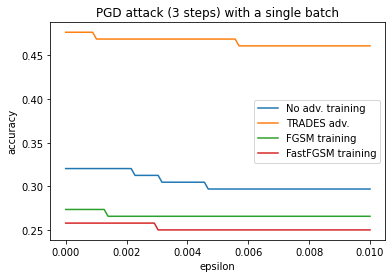

In [ ]:
# plot lines
plt.plot(eps, accuracy_normal, label = "No adv. training")
plt.plot(eps, accuracy_trades, label = "TRADES adv.")
plt.plot(eps, accuracy_fgsm, label = "FGSM training")
plt.plot(eps, accuracy_fastfgsm, label = "FastFGSM training")
plt.title("PGD attack (3 steps) with a single batch")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [ ]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params


x, y = next(iter(test_loader))
x = x.to('cuda').float()

eps = np.linspace(0.001, 0.1, num=100)
accuracy_normal  = []
accuracy_trades = []
accuracy_fgsm = []
accuracy_fastfgsm = []

for e in eps:

    adversary1 = FGSM(ResNet18_normal, 'cuda')
    Adv_img1 = adversary1.generate(x, y, **{
        'epsilon': e,
        'order' : np.inf,
        })

    adversary2 = FGSM(ResNet18_robust_TRADES, 'cuda')
    Adv_img2 = adversary2.generate(x, y, **{
        'epsilon': e,
        'order' : np.inf,
        })


    adversary3 = FGSM(ResNet18_robust_FGSM, 'cuda')
    Adv_img3 = adversary3.generate(x, y, **{
        'epsilon': e,
        'order' : np.inf,
        })
    
    adversary4 = FGSM(ResNet18_robust_FastFGSM)
    Adv_img4 = adversary4.generate(x, y, **{
        'epsilon': e,
        'order' : np.inf,
        })



    
    correct_normal=0
    preds = ResNet18_normal(Adv_img1)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_normal += predicted.eq(y.data).cpu().sum().item()
    acc1 = correct_normal/128
    
    correct_trades=0
    preds = ResNet18_robust_TRADES(Adv_img2)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_trades += predicted.eq(y.data).cpu().sum().item()
    acc2 = correct_trades/128

    correct_fgsm=0
    preds = ResNet18_robust_FGSM(Adv_img3)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_fgsm += predicted.eq(y.data).cpu().sum().item()
    acc3 = correct_fgsm/128

    correct_fastfgsm=0
    preds = ResNet18_robust_FastFGSM(Adv_img4)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_fastfgsm += predicted.eq(y.data).cpu().sum().item()
    acc4 = correct_fastfgsm/128

    accuracy_normal.append(acc1)
    accuracy_trades.append(acc2)
    accuracy_fgsm.append(acc3)
    accuracy_fastfgsm.append(acc4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


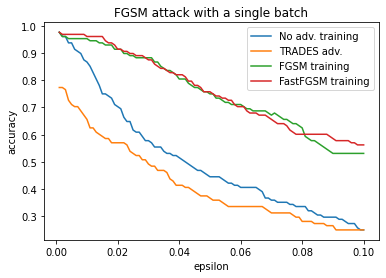

In [ ]:
# plot lines
plt.plot(eps, accuracy_normal, label = "No adv. training")
plt.plot(eps, accuracy_trades, label = "TRADES adv.")
plt.plot(eps, accuracy_fgsm, label = "FGSM training")
plt.plot(eps, accuracy_fastfgsm, label = "FastFGSM training")
plt.title("FGSM attack with a single batch")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.legend()
plt.show()

Let's see the adversarail images using the same library DeepRobust. This allows us to see better the perturbations.

In [23]:
images, labels = next(iter(test_loader))

adversary = PGD(ResNet18_normal, 'cuda')
adv_img = adversary.generate(images, labels, epsilon=0.05).cpu().detach()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


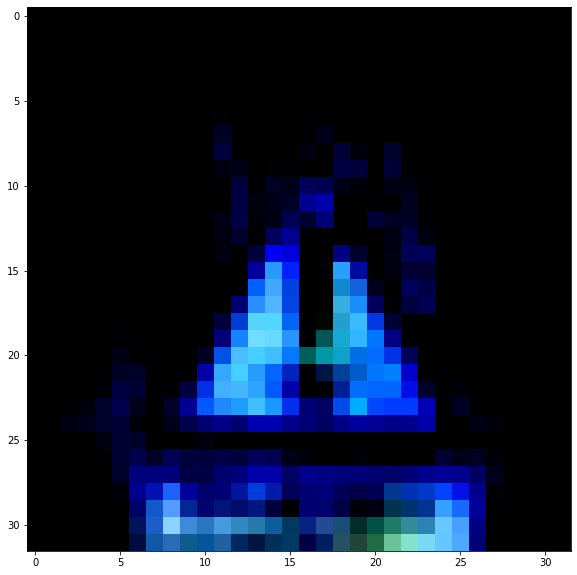

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(((torch.moveaxis((adv_img[34].cpu()).cpu(),0,2).cpu()).numpy() * 255).astype('uint8'))

# Contrastive Adversarial Learning 

Here below the code about Contrastive Adversarial Learning. 
First of all we need to reload the data and define the data augmentation with pairing.


In [31]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [32]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          #transforms.RandomResizedCrop(size=32),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.4,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.5),
                                          transforms.RandomGrayscale(p=0.4),
                                          transforms.GaussianBlur(kernel_size=3),
                                          transforms.RandomRotation(45),
                                          #transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                         ])

train_data_contrast = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/AML_project/myData', transform=ContrastiveTransformations(contrast_transforms, n_views=2))

train_loader = torch.utils.data.DataLoader(train_data_contrast, batch_size=128, shuffle=True,
                                     drop_last=False, pin_memory=True, num_workers=80)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 80 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Let's test the data augmentation using a batch.

In [34]:
images, labels = next(iter(train_loader))

print(images[0].shape, images[1].shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 80 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6ef798e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/

torch.Size([128, 3, 32, 32]) torch.Size([128, 3, 32, 32])


torch.Size([128])


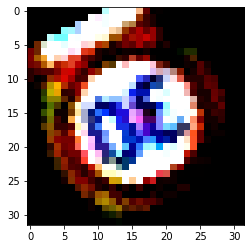

In [47]:
plt.imshow(images[0][48].permute(1,2,0))
print(labels.shape)

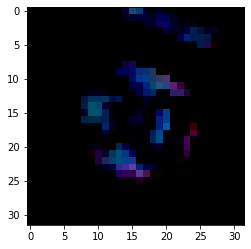

In [48]:
plt.imshow(images[1][48].permute(1,2,0))

ok perfect. The contrastive augmentation works.

In [49]:
# INSTALL NOW THE LIBRARY FOR THE LOSS
! pip install pytorch_metric_learning

     |████████████████████████████████| 102 kB 4.3 MB/s 


We are ready for contrastive adversarial training wiht A2S ( adversarail to standard ) framework.

In [50]:
from tqdm import tqdm
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

best_acc = 0  # best test accuracy

# Adversarial training using YOPO
def contrastive_adv_learning(epoch, loader , net, optimizer, loss_func, log_freq):

    net.train()
    running_loss=0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        

        #generate the origianl images and the augmented one
        inputs_original = inputs[0].to(device)
        inputs_augmented = inputs[1].to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        #generate now the adv images for the origianl ones.
        img_adversarial = generate_adversarail_YOPO(net, inputs_original, targets)
        

        #implement the Adversarial to Standard method.
        embeddings = net(img_adversarial)
        augmented = net(inputs_augmented)



        embeddings = torch.cat([embeddings, augmented], dim=0)
        
        targets = torch.cat([targets, targets], dim=0)

        #indices_tuple = mining_func(embeddings, targets)

        loss = loss_func(embeddings, targets) #+ loss_func(augmented, targets)

        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        #print statistics every log_freq mini batch
        #running_loss += loss.item()
        if (batch_idx) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, batch_idx, running_loss / log_freq))
            running_loss = 0.0
            #print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0
        
    torch.save({
          'epoch': epoch,
          'model_state_dict': net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, "/content/gdrive/MyDrive/AML_project/ResNet18_robust_CL.pt" )

    return losses




def generate_adversarail_YOPO(net, data, targets):
    
    adversary = FASTPGD(eps = 8 / 255.0, sigma = 3 / 255.0, nb_iter = 3, DEVICE=device)
    adv_img = adversary.attack(net, data, targets)  
    return adv_img

In [51]:
%cd /content/SupContrast

/content/SupContrast


Defining the Loss function using the metric-learning library.

In [52]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.1)(logits, torch.squeeze(labels))


criterion = SupervisedContrastiveLoss(temperature=0.1).to(device) # Custom Implementation

Pre-Training

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR
import losses
import foolbox
from deeprobust.image.attack.YOPOpgd import FASTPGD
from pytorch_metric_learning import losses


#MODEL WITH EMBEDDING OF 512
ResNet18_robust_CL = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_robust_CL.fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('fc2', nn.ReLU()),
    ('fc3', nn.Linear(1024, 512))
]))
ResNet18_robust_CL.fc = fc


#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_CL.to(device)


#hyperparameters
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
n_epochs = 30
learning_rate = 0.01
log_freq = 96   #value to see the logs
optimizer = optim.SGD(ResNet18_robust_CL.parameters(), lr=learning_rate, momentum=0.95, weight_decay=5e-4)



milestones = [10, 20, 35, 70]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.01)

for epoch in range(start_epoch, n_epochs):

    #train thje model1
    contrastive_adv_learning(epoch, train_loader, ResNet18_robust_CL, optimizer, criterion, log_freq)
    scheduler.step()

testing(ResNet18_robust_CL, test_loader)

  0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 80 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 1/572 [00:57<9:10:37, 57.86s/it]

[Epoch : 1, Iter:     0] loss: 0.078


 17%|█▋        | 97/572 [02:13<05:49,  1.36it/s]

[Epoch : 1, Iter:    96] loss: 5.468


 34%|███▎      | 193/572 [03:28<03:46,  1.67it/s]

[Epoch : 1, Iter:   192] loss: 5.401


 51%|█████     | 289/572 [04:40<03:44,  1.26it/s]

[Epoch : 1, Iter:   288] loss: 5.245


 67%|██████▋   | 385/572 [05:52<02:08,  1.46it/s]

[Epoch : 1, Iter:   384] loss: 5.085


 84%|████████▍ | 481/572 [07:03<01:23,  1.10it/s]

[Epoch : 1, Iter:   480] loss: 4.943


  0%|          | 1/572 [00:59<9:22:28, 59.10s/it]

[Epoch : 2, Iter:     0] loss: 0.048


 17%|█▋        | 97/572 [02:11<05:45,  1.38it/s]

[Epoch : 2, Iter:    96] loss: 4.748


 34%|███▎      | 193/572 [03:19<03:57,  1.59it/s]

[Epoch : 2, Iter:   192] loss: 4.655


 51%|█████     | 289/572 [04:27<03:09,  1.49it/s]

[Epoch : 2, Iter:   288] loss: 4.594


 67%|██████▋   | 385/572 [05:35<02:03,  1.51it/s]

[Epoch : 2, Iter:   384] loss: 4.483


 84%|████████▍ | 481/572 [06:45<02:16,  1.50s/it]

[Epoch : 2, Iter:   480] loss: 4.443


  0%|          | 1/572 [00:54<8:34:29, 54.06s/it]

[Epoch : 3, Iter:     0] loss: 0.044


 17%|█▋        | 97/572 [02:03<05:50,  1.36it/s]

[Epoch : 3, Iter:    96] loss: 4.271


 34%|███▎      | 193/572 [03:13<04:26,  1.42it/s]

[Epoch : 3, Iter:   192] loss: 4.286


 51%|█████     | 289/572 [04:19<03:20,  1.41it/s]

[Epoch : 3, Iter:   288] loss: 4.189


 67%|██████▋   | 385/572 [05:25<01:49,  1.71it/s]

[Epoch : 3, Iter:   384] loss: 4.148


 84%|████████▍ | 481/572 [06:38<02:39,  1.76s/it]

[Epoch : 3, Iter:   480] loss: 4.060


  0%|          | 1/572 [00:53<8:30:32, 53.65s/it]

[Epoch : 4, Iter:     0] loss: 0.041


 17%|█▋        | 97/572 [02:02<05:07,  1.54it/s]

[Epoch : 4, Iter:    96] loss: 3.988


 34%|███▎      | 193/572 [03:09<04:28,  1.41it/s]

[Epoch : 4, Iter:   192] loss: 3.914


 51%|█████     | 289/572 [04:20<03:29,  1.35it/s]

[Epoch : 4, Iter:   288] loss: 3.941


 67%|██████▋   | 385/572 [05:35<02:05,  1.49it/s]

[Epoch : 4, Iter:   384] loss: 3.872


 84%|████████▍ | 481/572 [07:05<03:54,  2.58s/it]

[Epoch : 4, Iter:   480] loss: 3.866


  0%|          | 1/572 [01:04<10:16:47, 64.81s/it]

[Epoch : 5, Iter:     0] loss: 0.040


 17%|█▋        | 97/572 [02:39<06:38,  1.19it/s]

[Epoch : 5, Iter:    96] loss: 3.755


 34%|███▎      | 193/572 [04:10<05:27,  1.16it/s]

[Epoch : 5, Iter:   192] loss: 3.805


 51%|█████     | 289/572 [05:37<03:33,  1.32it/s]

[Epoch : 5, Iter:   288] loss: 3.781


 67%|██████▋   | 385/572 [07:04<01:58,  1.57it/s]

[Epoch : 5, Iter:   384] loss: 3.700


 84%|████████▍ | 481/572 [08:31<03:54,  2.57s/it]

[Epoch : 5, Iter:   480] loss: 3.690


  0%|          | 1/572 [01:10<11:15:22, 70.97s/it]

[Epoch : 6, Iter:     0] loss: 0.037


 17%|█▋        | 97/572 [02:44<06:35,  1.20it/s]

[Epoch : 6, Iter:    96] loss: 3.662


 34%|███▎      | 193/572 [04:11<04:58,  1.27it/s]

[Epoch : 6, Iter:   192] loss: 3.613


 51%|█████     | 289/572 [05:46<05:03,  1.07s/it]

[Epoch : 6, Iter:   288] loss: 3.527


 67%|██████▋   | 385/572 [07:20<03:04,  1.01it/s]

[Epoch : 6, Iter:   384] loss: 3.639


 84%|████████▍ | 481/572 [08:52<04:26,  2.93s/it]

[Epoch : 6, Iter:   480] loss: 3.544


  0%|          | 1/572 [01:12<11:25:53, 72.07s/it]

[Epoch : 7, Iter:     0] loss: 0.040


 17%|█▋        | 97/572 [02:41<07:01,  1.13it/s]

[Epoch : 7, Iter:    96] loss: 3.507


 34%|███▎      | 193/572 [04:04<04:25,  1.43it/s]

[Epoch : 7, Iter:   192] loss: 3.517


 51%|█████     | 289/572 [05:31<04:05,  1.15it/s]

[Epoch : 7, Iter:   288] loss: 3.516


 67%|██████▋   | 385/572 [07:01<02:35,  1.21it/s]

[Epoch : 7, Iter:   384] loss: 3.466


 84%|████████▍ | 481/572 [08:31<03:11,  2.10s/it]

[Epoch : 7, Iter:   480] loss: 3.421


  0%|          | 1/572 [01:14<11:51:16, 74.74s/it]

[Epoch : 8, Iter:     0] loss: 0.037


 17%|█▋        | 97/572 [02:48<07:35,  1.04it/s]

[Epoch : 8, Iter:    96] loss: 3.410


 34%|███▎      | 193/572 [04:20<06:00,  1.05it/s]

[Epoch : 8, Iter:   192] loss: 3.394


 51%|█████     | 289/572 [05:48<03:37,  1.30it/s]

[Epoch : 8, Iter:   288] loss: 3.397


 67%|██████▋   | 385/572 [07:19<02:37,  1.19it/s]

[Epoch : 8, Iter:   384] loss: 3.452


 84%|████████▍ | 480/572 [08:45<01:16,  1.20it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_wo

[Epoch : 8, Iter:   480] loss: 3.400


  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f

[Epoch : 9, Iter:     0] loss: 0.036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  0%|          | 2/572 [01:29<5:52:24, 37.10s/it] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_w

[Epoch : 9, Iter:    96] loss: 3.325


 34%|███▎      | 193/572 [04:46<06:19,  1.00s/it]

[Epoch : 9, Iter:   192] loss: 3.399


 51%|█████     | 289/572 [06:20<04:07,  1.15it/s]

[Epoch : 9, Iter:   288] loss: 3.332


 67%|██████▋   | 385/572 [07:52<02:58,  1.05it/s]

[Epoch : 9, Iter:   384] loss: 3.349


 84%|████████▍ | 481/572 [09:36<05:03,  3.33s/it]

[Epoch : 9, Iter:   480] loss: 3.276


  0%|          | 1/572 [01:19<12:37:29, 79.60s/it]

[Epoch : 10, Iter:     0] loss: 0.037


 17%|█▋        | 97/572 [02:56<07:51,  1.01it/s]

[Epoch : 10, Iter:    96] loss: 3.287


 34%|███▎      | 193/572 [04:26<05:22,  1.18it/s]

[Epoch : 10, Iter:   192] loss: 3.272


 51%|█████     | 289/572 [06:01<04:23,  1.07it/s]

[Epoch : 10, Iter:   288] loss: 3.273


 56%|█████▌    | 320/572 [06:27<03:16,  1.29it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
 56%|█████▌    | 321/572 [06:39<16:24,  3.92s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/util

[Epoch : 10, Iter:   384] loss: 3.297


 70%|██████▉   | 400/572 [07:43<02:31,  1.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_wo

[Epoch : 10, Iter:   480] loss: 3.244


  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fafa16143b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1

[Epoch : 11, Iter:     0] loss: 0.030


 17%|█▋        | 97/572 [02:29<05:16,  1.50it/s]

[Epoch : 11, Iter:    96] loss: 3.207


 34%|███▎      | 193/572 [03:49<04:30,  1.40it/s]

[Epoch : 11, Iter:   192] loss: 3.070


 51%|█████     | 289/572 [05:08<03:28,  1.35it/s]

[Epoch : 11, Iter:   288] loss: 3.106


 67%|██████▋   | 385/572 [06:26<02:21,  1.32it/s]

[Epoch : 11, Iter:   384] loss: 3.033


 84%|████████▍ | 481/572 [07:52<03:34,  2.35s/it]

[Epoch : 11, Iter:   480] loss: 3.032


  0%|          | 1/572 [01:09<11:02:29, 69.61s/it]

[Epoch : 12, Iter:     0] loss: 0.033


 17%|█▋        | 97/572 [02:43<05:53,  1.35it/s]

[Epoch : 12, Iter:    96] loss: 2.999


 34%|███▎      | 193/572 [04:16<05:33,  1.14it/s]

[Epoch : 12, Iter:   192] loss: 3.044


 51%|█████     | 289/572 [05:44<03:56,  1.20it/s]

[Epoch : 12, Iter:   288] loss: 2.980


 67%|██████▋   | 385/572 [07:15<02:30,  1.24it/s]

[Epoch : 12, Iter:   384] loss: 2.977


 84%|████████▍ | 481/572 [08:53<03:53,  2.57s/it]

[Epoch : 12, Iter:   480] loss: 2.971


  0%|          | 1/572 [01:06<10:30:21, 66.24s/it]

[Epoch : 13, Iter:     0] loss: 0.033


 17%|█▋        | 97/572 [02:34<06:10,  1.28it/s]

[Epoch : 13, Iter:    96] loss: 2.983


 34%|███▎      | 193/572 [03:53<04:14,  1.49it/s]

[Epoch : 13, Iter:   192] loss: 2.946


 51%|█████     | 289/572 [05:13<03:30,  1.34it/s]

[Epoch : 13, Iter:   288] loss: 2.979


 67%|██████▋   | 385/572 [06:27<02:13,  1.40it/s]

[Epoch : 13, Iter:   384] loss: 2.934


 84%|████████▍ | 481/572 [07:47<01:41,  1.11s/it]

[Epoch : 13, Iter:   480] loss: 2.960


  0%|          | 1/572 [01:05<10:21:00, 65.25s/it]

[Epoch : 14, Iter:     0] loss: 0.031


 17%|█▋        | 97/572 [02:29<06:30,  1.22it/s]

[Epoch : 14, Iter:    96] loss: 2.944


 34%|███▎      | 193/572 [03:48<04:29,  1.41it/s]

[Epoch : 14, Iter:   192] loss: 2.924


 51%|█████     | 289/572 [05:06<03:33,  1.33it/s]

[Epoch : 14, Iter:   288] loss: 2.931


 67%|██████▋   | 385/572 [06:37<02:08,  1.46it/s]

[Epoch : 14, Iter:   384] loss: 2.901


 84%|████████▍ | 481/572 [08:04<05:36,  3.69s/it]

[Epoch : 14, Iter:   480] loss: 2.938


  0%|          | 1/572 [01:19<12:34:47, 79.31s/it]

[Epoch : 15, Iter:     0] loss: 0.028


 17%|█▋        | 97/572 [02:52<06:48,  1.16it/s]

[Epoch : 15, Iter:    96] loss: 2.869


 34%|███▎      | 193/572 [04:22<05:25,  1.17it/s]

[Epoch : 15, Iter:   192] loss: 2.940


 51%|█████     | 289/572 [05:54<03:48,  1.24it/s]

[Epoch : 15, Iter:   288] loss: 2.963


 67%|██████▋   | 385/572 [07:27<03:21,  1.08s/it]

[Epoch : 15, Iter:   384] loss: 2.911


 84%|████████▍ | 481/572 [09:10<05:44,  3.78s/it]

[Epoch : 15, Iter:   480] loss: 2.908


  0%|          | 1/572 [01:15<12:02:48, 75.95s/it]

[Epoch : 16, Iter:     0] loss: 0.033


 17%|█▋        | 97/572 [02:51<06:06,  1.29it/s]

[Epoch : 16, Iter:    96] loss: 2.895


 34%|███▎      | 193/572 [04:28<06:34,  1.04s/it]

[Epoch : 16, Iter:   192] loss: 2.956


 51%|█████     | 289/572 [06:01<04:16,  1.10it/s]

[Epoch : 16, Iter:   288] loss: 2.883


 67%|██████▋   | 385/572 [07:31<02:27,  1.27it/s]

[Epoch : 16, Iter:   384] loss: 2.937


 84%|████████▍ | 481/572 [09:12<05:04,  3.35s/it]

[Epoch : 16, Iter:   480] loss: 2.886


  0%|          | 1/572 [01:17<12:12:57, 77.02s/it]

[Epoch : 17, Iter:     0] loss: 0.030


 17%|█▋        | 97/572 [02:52<06:41,  1.18it/s]

[Epoch : 17, Iter:    96] loss: 2.877


 34%|███▎      | 193/572 [04:24<05:32,  1.14it/s]

[Epoch : 17, Iter:   192] loss: 2.908


 51%|█████     | 289/572 [05:51<04:09,  1.13it/s]

[Epoch : 17, Iter:   288] loss: 2.911


 60%|██████    | 346/572 [06:55<03:41,  1.02it/s]

## CL Adversarial Testing

Load the model saved.

In [66]:
#MODEL TRADES
ResNet18_robust_CL = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_robust_CL.fc.in_features
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 1024)),
    ('fc2', nn.ReLU()),
    ('fc3', nn.Linear(1024, 512))
    #('fc3', nn.Linear(128, 43)),
    #('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_CL.fc = fc
print(ResNet18_robust_CL)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [67]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_CL.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/ResNet18_robust_CL_10epochs.pt")
ResNet18_robust_CL.load_state_dict(checkpoint["model_state_dict"])
#epoch = checkpoint['epoch']

print(ResNet18_robust_CL)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Remove the lasts layers and append just a layer in order to compare the model with the normal version without pre-training. But before we train the network with pre-training.

In [ ]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, 43)),
    #('fc2', nn.ReLU()),
    #('fc3', nn.Linear(128, 43))
    #('fc3', nn.Linear(128, 43)),
    #('output', nn.LogSoftmax(dim=1))
]))
ResNet18_robust_CL.fc = fc

#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_robust_CL.to(device)


#hyperparameters
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
n_epochs = 10
learning_rate = 0.0005
log_freq = 96   #value to see the logs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet18_robust_CL.parameters(), lr=learning_rate, weight_decay=5e-4)



milestones = [10, 20, 35, 70]
scheduler = MultiStepLR(optimizer, milestones, gamma=0.01)

for epoch in range(start_epoch, n_epochs):

    #train thje model1
    train(epoch, train_loader, ResNet18_robust_CL, optimizer, criterion, log_freq)
    validation(ResNet18_robust_CL, val_loader, "ResNet18_with_pre-training")
    scheduler.step()

testing(ResNet18_robust_CL, test_loader)



Load the normal model for the comparison.

In [69]:
#GPU normal models download 
#Standard Model
ResNet18_normal = torchvision.models.resnet18(pretrained=False)
num_ftrs = ResNet18_normal.fc.in_features
ResNet18_normal.fc = nn.Linear(num_ftrs, 43)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    ResNet18_normal.to(device)

checkpoint = torch.load("/content/gdrive/MyDrive/AML_project/ResNet10_cleanTraining.pt")
ResNet18_normal.load_state_dict(checkpoint["model_state_dict"])
epoch = checkpoint['epoch']

print(epoch)
testing(ResNet18_normal,test_loader)

8


  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 103/103 [02:07<00:00,  1.24s/it]

Top1 accuracy of the network on the normal test set: 97.96027094908288
Top3 accuracy of the network on the normal test set: 99.83255955552173
Top5 accuracy of the network on the normal test set: 99.9543344242332


Ready for the testing. PGD attacks with differnet ϵ.

In [77]:
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.config import attack_params


x, y = next(iter(test_loader))
x = x.to('cuda').float()

eps = np.linspace(0, 0.07, num=90)
accuracy_cl  = []
accuracy_normal = []

for e in eps:

    adversary1 = PGD(ResNet18_robust_CL, 'cuda')
    Adv_img1 = adversary1.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 5,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })
    
    adversary2 = PGD(ResNet18_normal, 'cuda')
    Adv_img2 = adversary2.generate(x, y, **{
        'epsilon' : e,
        'num_steps' : 5,
        'step_size' : 0.01,
        "clip_max" : 1.0,
        "clip_min" : 0.0,
        "print_process" : False,
        })
    
    correct_normal=0
    preds = ResNet18_robust_CL(Adv_img1)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_normal += predicted.eq(y.data).cpu().sum().item()
    acc1 = correct_normal/128

    correct_normal=0
    preds = ResNet18_normal(Adv_img2)
    _, predicted = torch.max(preds.data.cpu(), 1)
    correct_normal += predicted.eq(y.data).cpu().sum().item()
    acc2 = correct_normal/128



    accuracy_cl.append(acc1)
    accuracy_normal.append(acc2)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


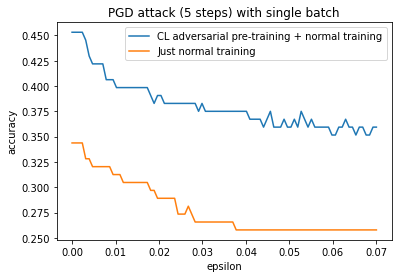

In [79]:
# plot lines
plt.plot(eps, accuracy_cl, label = "CL adversarial pre-training + normal training")
plt.plot(eps, accuracy_normal, label = "Just normal training")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.title("PGD attack (5 steps) with single batch")
plt.legend()
plt.show()